In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Paths to input image and corresponding mask
original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23GFNI5.1.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground51.tif'

# Output directories for sliced patches
out_img_dir = 'dataset51/images/'
out_mask_dir = 'dataset51/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)

patch_size = 256
stride = 256

# Load image and mask
img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Resize mask if shape doesn't match
if img.shape[:2] != mask.shape:
    print("Image and mask shape mismatch — resizing needed")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

count = 0
h, w = img.shape[:2]

# Slide window and extract patches
for y in tqdm(range(0, h - patch_size + 1, stride), desc="Slicing rows"):
    for x in range(0, w - patch_size + 1, stride):
        patch_img = img[y:y+patch_size, x:x+patch_size]
        patch_mask = mask[y:y+patch_size, x:x+patch_size]

        img_name = f'img_{count:04d}.png'
        cv2.imwrite(os.path.join(out_img_dir, img_name), patch_img)
        cv2.imwrite(os.path.join(out_mask_dir, img_name), patch_mask)

        count += 1

print(f"Saved {count} patches to dataset/images/ and dataset/masks/")


Slicing rows: 100%|██████████| 8/8 [00:00<00:00, 10.15it/s]

Saved 88 patches to dataset/images/ and dataset/masks/


In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Image size and number of classes
IMG_SIZE = 256
NUM_CLASSES = 3  # class 0: black (matrix), class 1: gray (other minerals), class 2: white (clasts)

# Function to load and preprocess images and masks
def load_data(image_dir, mask_dir):
    # Get sorted list of image and mask filenames
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []  # images
    Y = []  # masks

    for img_name, mask_name in zip(image_files, mask_files):
        # Read and normalize image
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0)

        # Read and resize mask (grayscale)
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        # Create binary masks for each class based on pixel intensity
        class_0 = (mask < 64)                    # black → class 0
        class_1 = (mask >= 64) & (mask < 192)    # gray → class 1
        class_2 = (mask >= 192)                  # white → class 2

        # Initialize empty mask and assign class IDs
        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

        # Convert to one-hot encoding
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)

# Load and preprocess data
X, Y = load_data('dataset51/images/', 'dataset51/masks/')

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print shape info
print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (88, 256, 256, 3)
Y: (88, 256, 256, 3)


Building the model

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3), num_classes=3):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(16, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

    # Output layer with softmax for multi-class segmentation
    outputs = Conv2D(num_classes, 1, activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


Epoch 1/30
9/9 [==============================] - 15s 1s/step - loss: 1.0934 - accuracy: 0.3999 - val_loss: 0.9910 - val_accuracy: 0.6485
Epoch 2/30
9/9 [==============================] - 12s 1s/step - loss: 0.8947 - accuracy: 0.6483 - val_loss: 0.8180 - val_accuracy: 0.6494
Epoch 3/30
9/9 [==============================] - 13s 1s/step - loss: 0.7931 - accuracy: 0.6479 - val_loss: 0.7549 - val_accuracy: 0.6494
Epoch 4/30
9/9 [==============================] - 13s 1s/step - loss: 0.7299 - accuracy: 0.6484 - val_loss: 0.7142 - val_accuracy: 0.6494
Epoch 5/30
9/9 [==============================] - 12s 1s/step - loss: 0.6993 - accuracy: 0.6484 - val_loss: 0.6905 - val_accuracy: 0.6494
Epoch 6/30
9/9 [==============================] - 12s 1s/step - loss: 0.6745 - accuracy: 0.6484 - val_loss: 0.6823 - val_accuracy: 0.6494
Epoch 7/30
9/9 [==============================] - 13s 1s/step - loss: 0.6412 - accuracy: 0.6484 - val_loss: 0.6170 - val_accuracy: 0.6494
Epoch 8/30
9/9 [==================

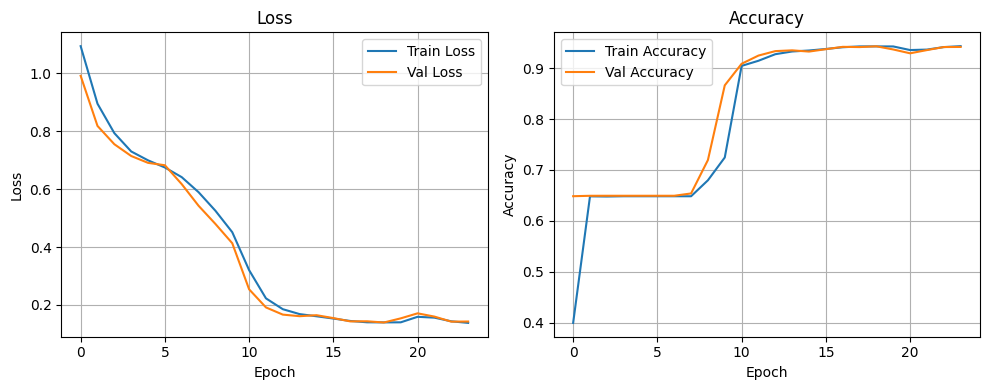

In [12]:
# Build and compile the U-Net model
model = unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('unet_1.h5', save_best_only=True),  # save best model
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)  # stop early if no improvement
    ]
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get model predictions on validation data
pred_probs = model.predict(X_val)

# Convert softmax probabilities to class indices
pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

In [13]:
#Predict
pred_probs = model.predict(X_val)


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 775ms/step


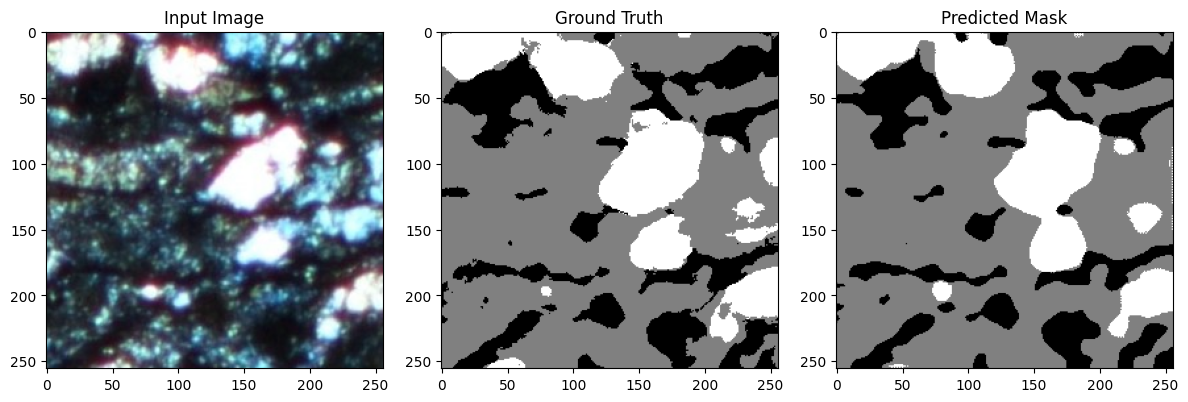

In [14]:
#Plot
import matplotlib.pyplot as plt

i = 0  

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

Same process for another image

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm


original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23GFAY21XleftYup IMG.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truth21.tif' 


out_img_dir = 'dataset21/images/'
out_mask_dir = 'dataset21/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


patch_size = 256
stride = 256  


img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img.shape[:2] != mask.shape:
    print("Image and mask shape mismatch — resizing needed")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


count = 0
h, w = img.shape[:2]

for y in tqdm(range(0, h - patch_size + 1, stride), desc="Slicing rows"):
    for x in range(0, w - patch_size + 1, stride):
        patch_img = img[y:y+patch_size, x:x+patch_size]
        patch_mask = mask[y:y+patch_size, x:x+patch_size]

        img_name = f'img_{count:04d}.png'
        cv2.imwrite(os.path.join(out_img_dir, img_name), patch_img)
        cv2.imwrite(os.path.join(out_mask_dir, img_name), patch_mask)

        count += 1

print(f"Saved {count} patches to dataset/images/ and dataset/masks/")

Slicing rows: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s]

Saved 54 patches to dataset/images/ and dataset/masks/


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
       
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0) 
       
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

       
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

       
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset21/images/', 'dataset21/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (54, 256, 256, 3)
Y: (54, 256, 256, 3)


# Retrainng the model obtianed from training in Mariposa.ipynb file

In [8]:
from tensorflow.keras.models import load_model

model = load_model("unet_1_finetuned2.h5", compile=False)


In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/30
5/5 [==============================] - 10s 1s/step - loss: 0.9451 - accuracy: 0.7242 - val_loss: 0.4255 - val_accuracy: 0.8329
Epoch 2/30
5/5 [==============================] - 6s 1s/step - loss: 0.3351 - accuracy: 0.8638 - val_loss: 0.4414 - val_accuracy: 0.8105
Epoch 3/30
5/5 [==============================] - 6s 1s/step - loss: 0.3393 - accuracy: 0.8657 - val_loss: 0.2956 - val_accuracy: 0.8761
Epoch 4/30
5/5 [==============================] - 6s 1s/step - loss: 0.3121 - accuracy: 0.8679 - val_loss: 0.2979 - val_accuracy: 0.8764
Epoch 5/30
5/5 [==============================] - 6s 1s/step - loss: 0.2647 - accuracy: 0.8974 - val_loss: 0.2974 - val_accuracy: 0.8876
Epoch 6/30
5/5 [==============================] - 6s 1s/step - loss: 0.2658 - accuracy: 0.8990 - val_loss: 0.2615 - val_accuracy: 0.8946
Epoch 7/30
5/5 [==============================] - 6s 1s/step - loss: 0.2410 - accuracy: 0.9015 - val_loss: 0.2527 - val_accuracy: 0.8940
Epoch 8/30
5/5 [========================

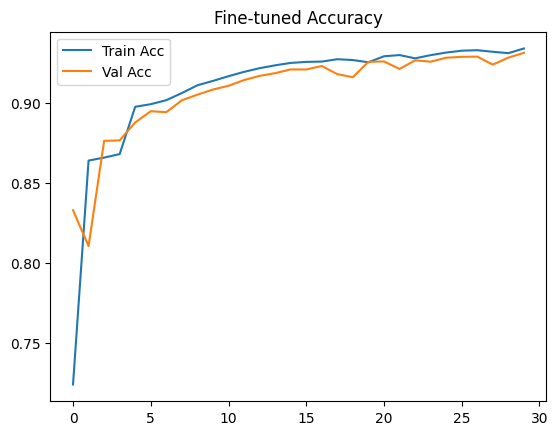

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=[
        ModelCheckpoint('unet_1_finetuned3.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Fine-tuned Accuracy")
plt.legend()
plt.show()


In [11]:
pred_probs = model.predict(X_val)


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 579ms/step


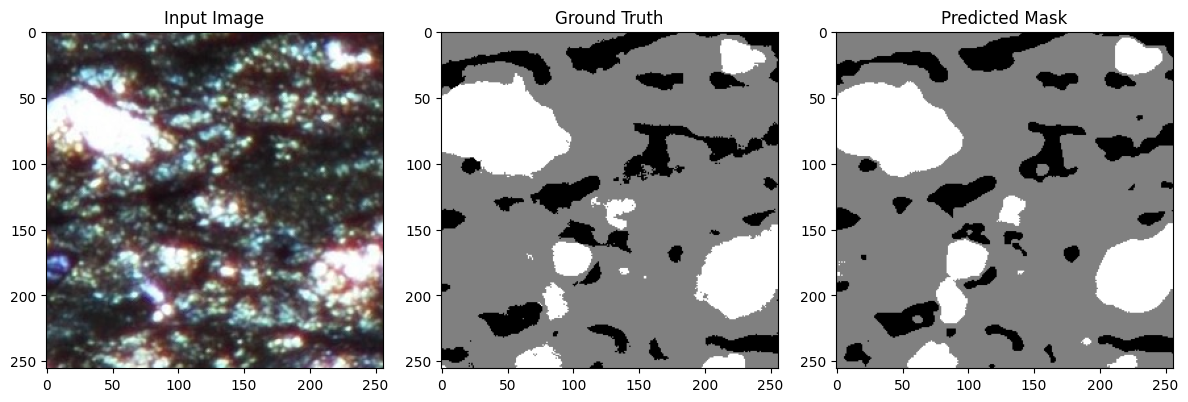

In [12]:
import matplotlib.pyplot as plt

i = 0  

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm


original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23GFNI1.1yleftzup IMG.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truthgf11.tif'  


out_img_dir = 'datasetgf11/images/'
out_mask_dir = 'datasetgf11/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


patch_size = 256
stride = 256  


img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img.shape[:2] != mask.shape:
    print("Image and mask shape mismatch — resizing needed")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


count = 0
h, w = img.shape[:2]

for y in tqdm(range(0, h - patch_size + 1, stride), desc="Slicing rows"):
    for x in range(0, w - patch_size + 1, stride):
        patch_img = img[y:y+patch_size, x:x+patch_size]
        patch_mask = mask[y:y+patch_size, x:x+patch_size]

        img_name = f'img_{count:04d}.png'
        cv2.imwrite(os.path.join(out_img_dir, img_name), patch_img)
        cv2.imwrite(os.path.join(out_mask_dir, img_name), patch_mask)

        count += 1

print(f"Saved {count} patches to dataset/images/ and dataset/masks/")

Slicing rows: 100%|██████████| 6/6 [00:00<00:00, 15.67it/s]

Saved 48 patches to dataset/images/ and dataset/masks/


In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
       
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0) 

     
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

       
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('datasetgf11/images/', 'datasetgf11/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (48, 256, 256, 3)
Y: (48, 256, 256, 3)


In [7]:
from tensorflow.keras.models import load_model

model = load_model("unet_1_finetuned4.h5", compile=False)

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/30
4/4 [==============================] - 12s 2s/step - loss: 0.6066 - accuracy: 0.7638 - val_loss: 0.6161 - val_accuracy: 0.8359
Epoch 2/30
4/4 [==============================] - 6s 1s/step - loss: 0.3191 - accuracy: 0.8874 - val_loss: 0.3380 - val_accuracy: 0.8457
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.2609 - accuracy: 0.8860 - val_loss: 0.2124 - val_accuracy: 0.9153
Epoch 4/30
4/4 [==============================] - 6s 1s/step - loss: 0.2262 - accuracy: 0.9076 - val_loss: 0.2100 - val_accuracy: 0.9137
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.1953 - accuracy: 0.9205 - val_loss: 0.2215 - val_accuracy: 0.9149
Epoch 6/30
4/4 [==============================] - 6s 1s/step - loss: 0.2020 - accuracy: 0.9207 - val_loss: 0.1964 - val_accuracy: 0.9268
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.1909 - accuracy: 0.9260 - val_loss: 0.2024 - val_accuracy: 0.9219
Epoch 8/30
4/4 [========================

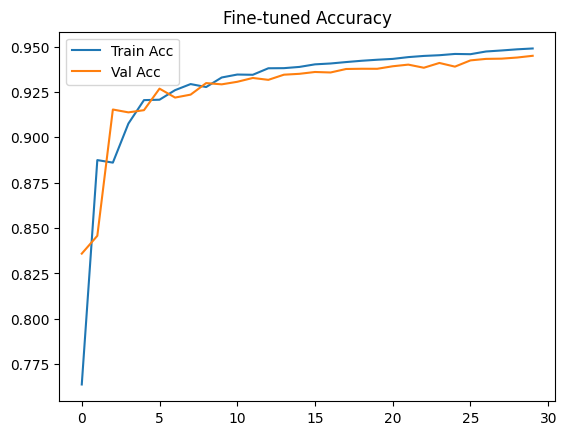

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=[
        ModelCheckpoint('unet_1_finetuned5.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Fine-tuned Accuracy")
plt.legend()
plt.show()


In [10]:
pred_probs = model.predict(X_val)


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 612ms/step


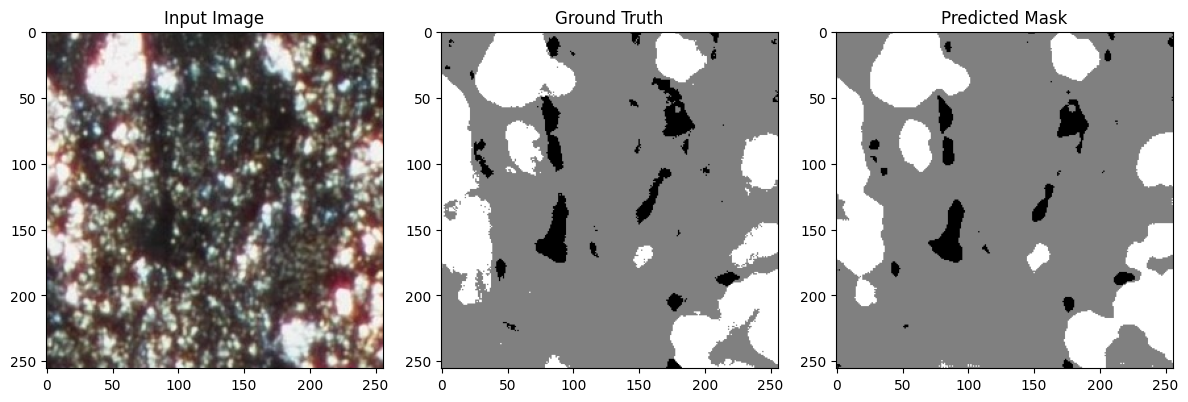

In [11]:
import matplotlib.pyplot as plt

i = 0 
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

## Applying Augmentation to the final finetuned model

In [15]:
from sklearn.model_selection import train_test_split

# Further split training data into train and validation for augmentation (optional fine-tuning split)
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for input images
image_datagen = ImageDataGenerator(
    rotation_range=10,         # rotate images by up to ±10 degrees
    zoom_range=0.1,            # zoom in/out by up to 10%
    width_shift_range=0.05,    # shift left/right by 5% of width
    height_shift_range=0.05,   # shift up/down by 5% of height
    horizontal_flip=True,      # randomly flip images horizontally
    vertical_flip=True,        # randomly flip images vertically
    fill_mode='nearest'        # fill empty pixels after transformation
)

# Apply same augmentations to masks (no rescaling or normalization!)
mask_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Initialize generators with the same seed to ensure synchronized augmentation
seed = 42
image_generator = image_datagen.flow(X_train_split, batch_size=8, seed=seed)
mask_generator = mask_datagen.flow(Y_train_split, batch_size=8, seed=seed)

# Combine image and mask generators into a single training generator
train_generator = zip(image_generator, mask_generator)


In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train_split) // 8,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[
        ModelCheckpoint('unet_1_augmented_fine.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/30
3/3 [==============================] - 4s 2s/step - loss: 0.1460 - accuracy: 0.9418 - val_loss: 0.1228 - val_accuracy: 0.9481
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.1392 - accuracy: 0.9446 - val_loss: 0.1403 - val_accuracy: 0.9397
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 0.1414 - accuracy: 0.9426 - val_loss: 0.1301 - val_accuracy: 0.9444
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 0.1477 - accuracy: 0.9411 - val_loss: 0.1313 - val_accuracy: 0.9458
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 0.1569 - accuracy: 0.9366 - val_loss: 0.1308 - val_accuracy: 0.9448
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 0.1474 - accuracy: 0.9416 - val_loss: 0.1383 - val_accuracy: 0.9396


In [17]:
pred_probs = model.predict(X_val)

pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 0s 339ms/step


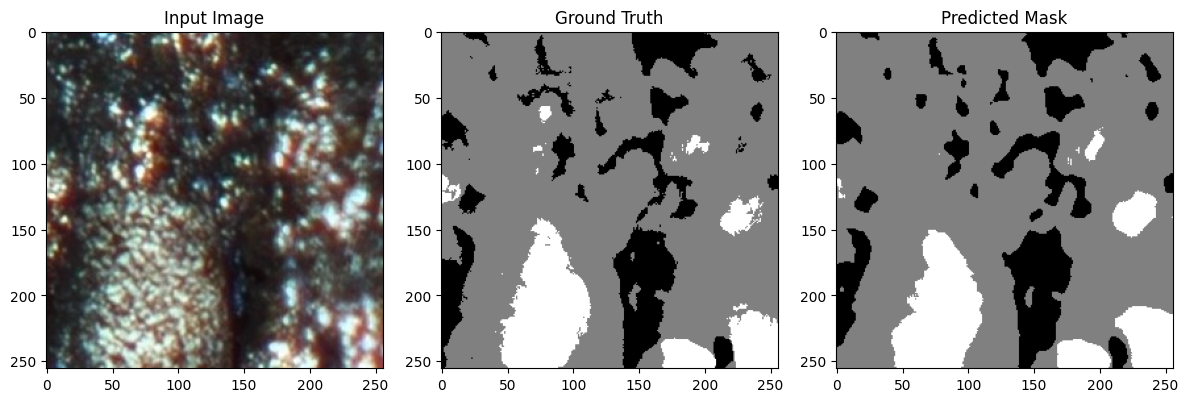

In [18]:
import matplotlib.pyplot as plt

i = 0  

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

In [21]:
num_train_images = len(X_train_split)
batch_size = 8
epochs = 30

steps_per_epoch = num_train_images // batch_size
total_augmented_images = steps_per_epoch * batch_size * epochs

print("Original training images:", num_train_images)
print("Total augmented images generated during training:", total_augmented_images)

Original training images: 30
Total augmented images generated during training: 720
